# Task 4: Routing


## Partly reproduction of the star schema creation & population from the task 1 ETL pipeline

Including timetable change data is skipped due to not being needed for task 4 and a stand-alone pipeline is planned.



#### Connection Check
The first cells only make sure that the file root is set correct and the database connection is build.

In [1]:
import sys
from pathlib import Path

repo_root = Path("..").resolve()
if repo_root.as_posix() not in sys.path:
    sys.path.insert(0, repo_root.as_posix())

In [2]:
from src.timetable_etl.config import Settings
from src.timetable_etl.db import connect

settings = Settings.from_env()
print(settings)
conn = connect(settings)

Settings(db_host='localhost', db_name='postgres', db_user='postgres', db_password='1234', station_json_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/station_data.json'), planned_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetables'), changes_archives_path=PosixPath('/Users/rebeccamerdes/Desktop/TU/master/DIA/repo/DIA/DBahn-berlin/repo/timetable_changes'), archive_pattern='*.tar.gz', timezone='Europe/Berlin', match_threshold=0.75, ambiguity_delta=0.02, planned_batch_size=5000, change_batch_size=50000)


#### Step 0: Deduplication Investigation

We just wanted to show the we have investigated the duplicate keys exist in the ``stop_id`` attribute and thus, deduplication is necessary.

In [3]:
from src.timetable_etl.dedup_invest import count_stop_id_duplicates
import os
count_stop_id_duplicates(os.path.join(repo_root, "timetables"))

{'files_processed': 135692,
 'stop_id_total': 2104080,
 'stop_id_unique': 2085472,
 'stop_id_duplicates': 18608,
 'duplicate_ids': 18608}

#### Step 1: Build Station Table

The imported function reads the ``stations_data.json`` and builds the station dimension table from it.

In [4]:
from src.timetable_etl.stations import import_stationen

n = import_stationen(conn, settings.station_json_path)
print("Upserted station rows:", n)

Upserted station rows: 133


---

## Task 4-specific adaptions

#### Step 2: Build other Dimension Tables + Fact Table

The imported function builds the other dimension tables. Also, it iterates the ``timetables`` directory and inserts the planned values into the stops table.

In [5]:
from src.timetable_etl.stops_planned import import_stops_from_archives

planned_res = import_stops_from_archives(
    conn,
    settings.planned_archives_path,
    pattern=settings.archive_pattern,
    timezone=settings.timezone,
    match_threshold=settings.match_threshold,
    ambiguity_delta=settings.ambiguity_delta,
    batch_size=settings.planned_batch_size,
)
planned_res

{'archives_processed': 135692,
 'stops_upserted': 2094358,
 'unmatched_stations': []}

In [6]:
# todo: delete

conn.rollback()

with conn.cursor() as cur:
    cur.execute("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = 'public'
          AND table_name = 'stops'
        ORDER BY ordinal_position;
    """)
    cols = [r[0] for r in cur.fetchall()]

cols


['stop_id',
 'eva',
 'train_id',
 'arrival_pt_id',
 'departure_pt_id',
 'arrival_ct_id',
 'departure_ct_id',
 'arrival_clt_id',
 'departure_clt_id',
 'arrival_cs',
 'departure_cs',
 'arrival_pp',
 'departure_pp',
 'arrival_cp',
 'departure_cp',
 'stop_sequence_index']

### New step: add stop order index

In [7]:
# necessary?
#from src.timetable_etl.stop_sequence import ensure_stop_sequence_column

#conn.rollback()

#ensure_stop_sequence_column(conn)

In [8]:
conn.rollback() # todo: delete because redundant?
from src.timetable_etl.stop_sequence import compute_stop_sequence

compute_stop_sequence(conn)

# please note: the stop_sequence_index denotes the position within the stop order sequence. it has nothing to do with a database index.


## 4.1: Shortest route (graph building)

* nodes: stations (identified by eva)
* edges: connections between stops, created from stop_sequence_index = i -> i+1 for same train at same service time frame

In [9]:
from src.timetable_etl.station_graph import build_station_graph

# todo: try, catch, assert that nodes, edges exist
# add graph char from below
g_station, eva_to_vertex = build_station_graph(conn, True)

In [10]:
# get all station evas for easy start / goal reference
with conn.cursor() as cur:
    cur.execute("SELECT eva, name FROM stationen")
    eva_to_name = dict(cur.fetchall())

for eva, name in sorted(eva_to_name.items(), key=lambda x: x[1]):
    print(f"{eva}: {name}")

8011003: Ahrensfelde
8080040: Albrechtshof
8011155: Alexanderplatz
8089103: Alt-Reinickendorf
8089054: Altglienicke
8089003: Attilastraße
8089004: Baumschulenweg
8089005: Bellevue
8089002: Berlin Anhalter Bahnhof
8089044: Berlin Brandenburger Tor
8089013: Berlin Frankfurter Allee
8011102: Berlin Gesundbrunnen
8011160: Berlin Hauptbahnhof
8010255: Berlin Ostbahnhof
8011162: Berlin Ostkreuz
8011118: Berlin Potsdamer Platz
8011113: Berlin Südkreuz
8089051: Berlin Yorckstr.(S1)
8089050: Berlin Yorckstr.(S2)
8010406: Berlin Zoologischer Garten
8089052: Berlin-Adlershof
8089056: Berlin-Blankenburg
8089057: Berlin-Buch
8010403: Berlin-Charlottenburg
8089060: Berlin-Friedrichshagen
8011306: Berlin-Friedrichstraße
8089061: Berlin-Frohnau
8089062: Berlin-Grunewald
8089063: Berlin-Grünau
8089109: Berlin-Halensee
8089064: Berlin-Hermsdorf
8011901: Berlin-Hohenschönhausen
8010035: Berlin-Karlshorst
8011046: Berlin-Karow
8089068: Berlin-Kaulsdorf
8089069: Berlin-Köpenick
8010036: Berlin-Lichtenberg


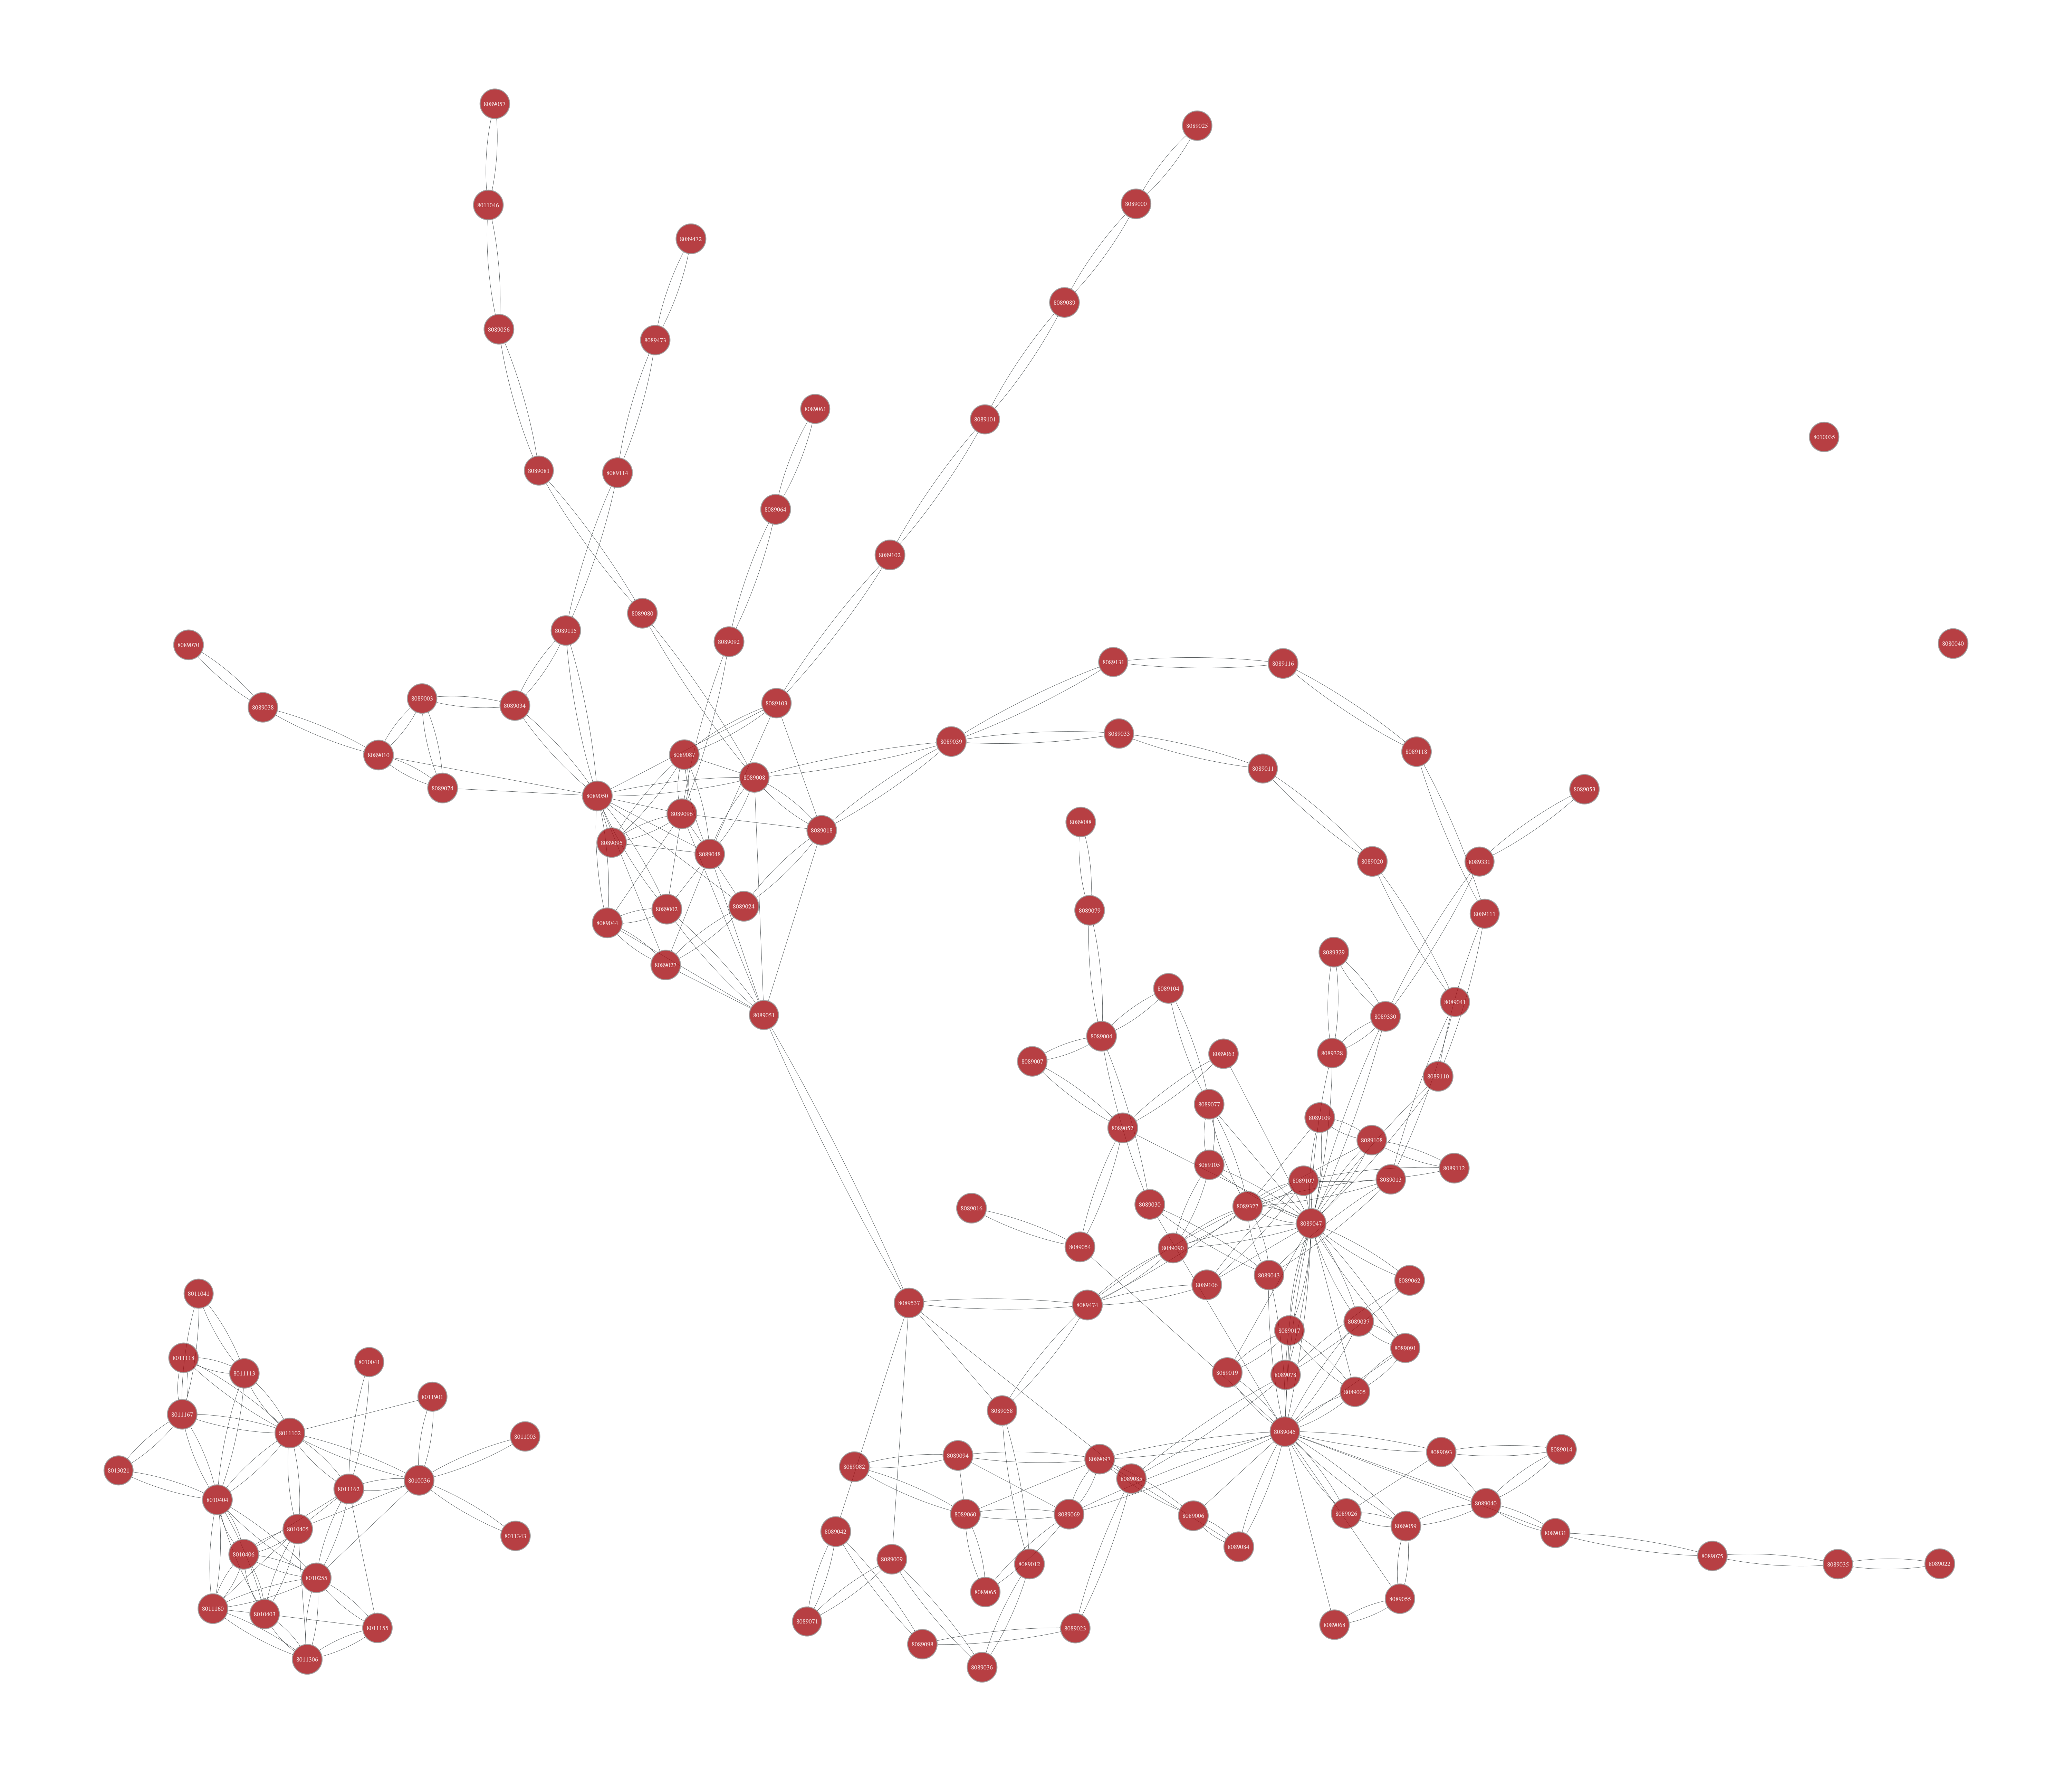

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x105f47f90, at 0x125a8b110>

In [11]:
import graph_tool.all as gt

# visualization of graph connections 
# please note: this shows only graph topology, not geographical relations
# (save and download to properly read eva numbers)

gt.graph_draw(
    g_station,
    output_size=(3000, 3000),
    vertex_size=15,
    edge_pen_width=0.5, 
    vertex_text=g_station.vertex_properties["eva"],
    bg_color="white"
)


#gt.graph_draw(g_station, vertex_text=g_station.vertex_properties["name"])


#### checks

In [12]:
# todo: nach oben schieben
# degree distribution
degrees = g_station.get_total_degrees(g_station.get_vertices())
print("max degree:", degrees.max())
print("mean degree:", degrees.mean())
print("isolated nodes:", (degrees == 0).sum())


max degree: 35
mean degree: 6.330827067669173
isolated nodes: 2


#### Path finding (graph hops)

In [13]:
from graph_tool.topology import all_shortest_paths

# todo: change request style?

#from_s =  eva_to_vertex[8011160] # hbf
#from_s = eva_to_vertex[8089131] # wedding
from_s = eva_to_vertex[8089039] # schönhauser alle
# from_s = eva_to_vertex[8089033] # prenzlauer alle
# from_s = eva_to_vertex[8011162] # ostkreuz

#to_s   = eva_to_vertex[8089091] # tiergarten
#to_s   = eva_to_vertex[8089118] # beusselstr
to_s = eva_to_vertex[8089013] # frankfurter str
#to_s = eva_to_vertex[8089041] # storkower str
#to_s = eva_to_vertex[8011162] # ostkreuz


paths = list(all_shortest_paths(g_station, from_s, to_s))

eva_prop = g_station.vertex_properties["eva"]

all_paths = [
    [eva_prop[v] for v in path]
    for path in paths
]

# for p in all_paths: # eva numbers
#    print(p)

# look at paths
name = g_station.vertex_properties["name"]

# todo: überschrift routenverlauf
# print "count of visited stations"
if len(paths) == 0:
    print("No paths found between ", name[from_s], " and ", name[to_s],"!")
else:
    for path in paths:
        print(" -> ".join(name[v] for v in path))

Schönhauser Allee -> Prenzlauer Allee -> Greifswalder Straße -> Landsberger Allee -> Storkower Straße -> Berlin Frankfurter Allee


In [14]:
# todo: delete?
# change to distinguish incoming <- and outgoing 

from src.timetable_etl.graph_helpers import print_station_edges

print_station_edges(g_station, 8089091, eva_to_vertex) # tiergarten
#print_station_edges(g_station, 8089011, eva_to_vertex) # greifswalder str
print_station_edges(g_station, 8011160, eva_to_vertex) # bhf
#print_station_edges(g_station, 8011162, eva_to_vertex) # ostkreuz



Connections of Tiergarten (8089091):
  -> Bellevue
  -> Savignyplatz
  -> Warschauer Straße
  -> Berlin-Westkreuz
  -> Savignyplatz
  -> Berlin-Westkreuz
  -> Bellevue
Connections of Berlin Hauptbahnhof (8011160):
  -> Berlin Ostbahnhof
  -> Berlin-Charlottenburg
  -> Berlin-Spandau
  -> Berlin Zoologischer Garten
  -> Berlin-Friedrichstraße
  -> Berlin-Spandau
  -> Berlin-Wannsee
  -> Berlin Zoologischer Garten
  -> Berlin Ostbahnhof
  -> Berlin-Friedrichstraße


---
### 4.2: Earliest arrival

In [32]:
# build graph with
# nodes = stations (eva) and trips
# edges = departure edge and arrival edge 

from src.timetable_etl.time_exp_station_graph import build_time_exp_graph

try:
    g_time, eva_to_v = build_time_exp_graph(conn)

    assert g_time.num_vertices() > 0, "graph has no vertices"
    assert g_time.num_edges() > 0, "graph has no edges"
    
except Exception as e:
    print("graph construction failed: ", e)
else: 
    print("time-expanded graph created with", g_time.num_vertices(), "nodes, ", g_time.num_edges(), "edges.")

time-expanded graph created with 1854293 nodes,  3708320 edges.


In [19]:
# ------> select here prefered start and goal station & departure time
from datetime import datetime, timezone



# --- ringbahn example
#start_eva = 8089039      # schönhauser allee <- attention: no s41 service before 8th of sep 2025 according to the data
#start_eva = 8089033      # prenzlauer allee <--/
#start_eva = 8089011      # greifswalder
#goal_eva  = 8089013      # frankfurter allee

# --- stations with different trains example
start_eva = 8089051 # yorckstr s1
goal_eva = 8089077 # neukölln

dep_time = datetime(
    2025, 9, 2, 16, 00,
    tzinfo=timezone.utc
)

In [29]:
#from src.timetable_etl.time_exp_station_graph import earliest_arrival, reconstruct_path
from src.timetable_etl.time_exp_st_gr_2 import earliest_arrival, reconstruct_path_with_edge_times
from datetime import datetime

# earliest arrival
dep_ts = int(dep_time.timestamp())
start_node = eva_to_v[start_eva]
goal_node = eva_to_v[goal_eva]

# find path
earliest, parent = earliest_arrival(
    g_time,
    start_node,
    goal_node,
    dep_ts
)

#earliest_ar_path = reconstruct_path(parent, start_node, goal_node)
earliest_ar_path = reconstruct_path_with_edge_times(parent, start_node, goal_node)

e_time = g_time.edge_properties["time"]
v_type = g_time.vertex_properties["type"]
v_name = g_time.vertex_properties["name"]
v_cat  = g_time.vertex_properties["category"]
v_line   = g_time.vertex_properties["line"]

current_time = dep_ts

# todo: überschrift

print("-> start at", v_name[start_node], "at", datetime.fromtimestamp(dep_ts, tz=timezone.utc), "\n")

# for v in earliest_ar_path:
#     if v_type[v] == "station":
#         print("station: ", v_name[v])
#     else:
#         print(f"-> take {v_cat[v]}{v_line[v]} ->")

for u, e, v in earliest_ar_path:
    t = e_time[e]

    if v_type[u] == "station" and v_type[v] != "station":
        # departure edge
        print(
            f"  depart from {v_name[u]} at",
            datetime.fromtimestamp(t, tz=timezone.utc), f"with {v_cat[v]}{v_line[v]}"

        )
        current_time = t

    elif v_type[u] != "station" and v_type[v] == "station":
        # arrival edge
        print(
            f"  arrive at {v_name[v]} at",
            datetime.fromtimestamp(t, tz=timezone.utc)
        )
        current_time = t

    else:
        print("! incorrect edge")

print("\n-> arrival at", v_name[goal_node], "at", datetime.fromtimestamp(earliest[goal_node], tz=timezone.utc))
print("-> travel time:", (datetime.fromtimestamp(earliest[goal_node], tz=timezone.utc) - datetime.fromtimestamp(dep_ts, tz=timezone.utc)))


-> start at Berlin Yorckstr.(S1) at 2025-09-02 16:00:00+00:00 

  depart from Berlin Yorckstr.(S1) at 2025-09-02 16:05:00+00:00 with S1
  arrive at Julius-Leber-Brücke at 2025-09-02 16:06:00+00:00
  depart from Julius-Leber-Brücke at 2025-09-02 16:06:00+00:00 with S1
  arrive at Schöneberg at 2025-09-02 16:08:00+00:00
  depart from Schöneberg at 2025-09-02 16:08:00+00:00 with S42
  arrive at Berlin-Tempelhof at 2025-09-02 16:12:00+00:00
  depart from Berlin-Tempelhof at 2025-09-02 16:13:00+00:00 with S42
  arrive at Hermannstraße at 2025-09-02 16:16:00+00:00
  depart from Hermannstraße at 2025-09-02 16:16:00+00:00 with S42
  arrive at Berlin-Neukölln at 2025-09-02 16:18:00+00:00

-> arrival at Berlin-Neukölln at 2025-09-02 16:18:00+00:00
-> travel time: 0:18:00


In [ ]:
conn.close()